Test the relationship between BCM rule and ICA


1. Generate sample s from identified independent resources (Laplace distribution) large enough sample size
2. Generate random mixing matrix A 2*2
3. Generate data samples $ s_{rt} = As $
4. Use sklearn, fast ICA, see weights and reconstruct the input: $ s_{rc} = ws_{rt} $
5. Use ICA objective function, see weights and outputs
6. Use BCM learning rule,see weights and outputs


Here we will simulation the effect of two neurons seperating to independent sources. The mixing matrix will be an rotation matrix $A = (cos\theta, -sin\theta;sin\theta,cos\theta)$

Generate sample from laplace distribuction: $p(s_{i}(t))\propto exp(-\sqrt2|s_{i}|)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
% matplotlib inline

In [3]:
# Define BCM class by quadratic learning rule
# Use iterative objective function
# Use tolerance to control # of iterations

class BCM:
    """BCM learning
    Parameter:
    eta: float, learning rate (between 0.0 - 1.0)
    n_iter: int, passes over the training dataset
    ny: number of output neurons
    batchsize: float, percentage of data that are used to update the weight once
    
    Attributes:
    w_: 1d-array, weights after fitting
    error_: list, number of misclassification in every epoch
    """
    def __init__(self, eta = 0.1,n_epoch = 10,ny = 1,tau = 10, batchsize = 10,thres = 0, p = 2,random_state = None, shuffle = True):
        self.eta = eta
        self.n_epoch = n_epoch
        self.ny = ny
        self.batchsize = batchsize
        self.tau = tau  # Time constant for calculating thresholds
        self.thres = [thres*np.ones(ny)]
        self.p = p    # int, power for threshold computation
        self.y_thres = []      # Storaged y for studying effect of threshold
        self.shuffle = shuffle
        
        if random_state:
            seed(random_state)
            
    def fit(self,X):
        """fitting training data
        Parameter:
        X: {array-like}, shape = [n_samples,n_features]
        Returns: self:object
        ny: value, number of output neurons
        """
        # Weights initialized as normal distribution
        self.w_ = np.random.randn(X.shape[1],self.ny) # 2*1
        self.w_track = []
#         np.zeros(self.n_epoch*X.shape[0],X.shape[1]*self.ny)   # n_interation rows, weight number of columns
        
        # Use elementwise training 
        threshold = np.zeros(2)
        for _ in range(self.n_epoch):
            if self.shuffle:
                X = self._shuffle(X)
            for i, xi in enumerate(X):   # elementwise training for all samples
                theta = np.zeros(2)
                y = np.zeros(2)
                for j in range(self.ny):
                    y[j] = np.dot(xi,self.w_[:,j])     
                    if y[j]<0:
                        y[j] = 0
                    self.w_[:,j][:,None] = self.w_[:,j][:,None]+ self.eta * xi[:,None]* y[j]*(y[j] - threshold[j])
                    h = np.exp(-1/self.tau)
                    y_power = y[j]**2
                    theta[j] = threshold[j]*self.tau*h+y_power
                    theta[j] = theta[j]/self.tau
                w_tmp = np.concatenate(self.w_.T, axis=0)    # make 2*2 matrix into 1*4, preparing for weight tracking
                self.y_thres.append(y)
                self.thres.append(theta)
                self.w_track.append(w_tmp.tolist())
                threshold = theta
        return self
    
    def _shuffle(self,X):
        r = np.random.permutation(len(X))
        return X[r]

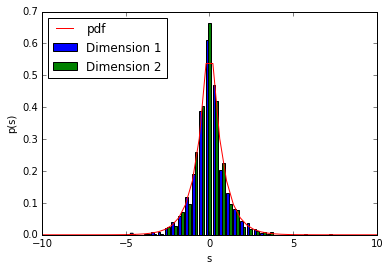

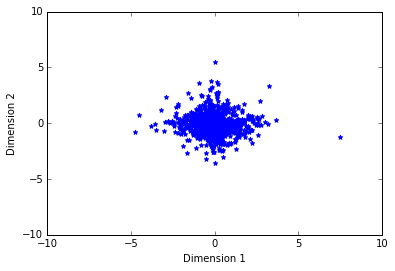

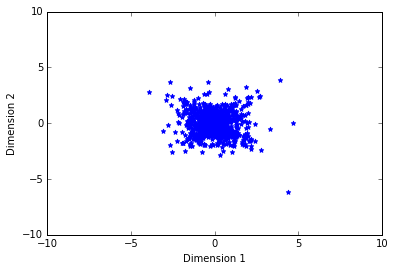

In [27]:
# Sample from the above distribution
loc = 0   # Mean zero
scale = (2**0.5)**(-1)
s = np.random.laplace(loc,scale,[1000,2])  # 5000*2, 0 mean, unit variance
count,bins,_ = plt.hist(s,30,normed = True)

# Plot the probability density function
x = np.linspace(-10, 10)
x_bin_size = np.diff(x)[1]
y = np.exp(-abs(x)/scale)/2/scale
y = y/sum(y)/x_bin_size
plt.plot(x,y,label = 'pdf')
plt.xlabel('s')
plt.ylabel('p(s)')
plt.legend(['pdf','Dimension 1','Dimension 2'],loc = 'upper left')
plt.figure()

# Generate 2d satter plot of sample
plt.scatter(s[:,0],s[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.axis([-10,10,-10,10]);

# Conduct rotation and mixture
# Generate rotatio matrix
import math as mt
theta = mt.pi/4      # 45 degree rotation
A = np.array(((mt.cos(theta),-mt.sin(theta)),(mt.sin(theta),mt.cos(theta))))
#A = np.random.randn(2,2)
#A = np.dot(A, A.T)
s_rt = np.dot(s,A)
# Generate 2d satter plot of the rotated data
plt.figure()
plt.scatter(s_rt[:,0],s_rt[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.axis([-10,10,-10,10]);

With ICA, a scalar factor is missing, but obtained the correct weight direction to demix the inputs

done in 0.627s


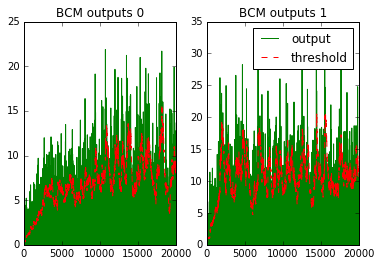

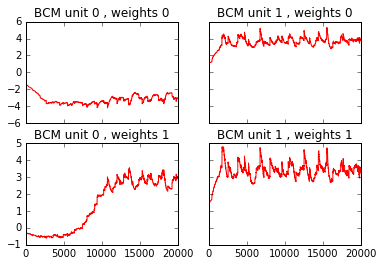

In [57]:
# Train BCM model with Laplace data

ny = 2    # 2 output neurons
n_epoch = 20
p = 2
eta = 0.0005
tau = 200
BCM_laplace = BCM(eta = eta,n_epoch = n_epoch,ny = 2,tau = 200, batchsize = 0,thres = 0, p = p,random_state = None, shuffle = True)

t0 = time()
BCM_laplace.fit(s_rt)
print("done in %0.3fs" % (time()-t0))

#x_plot = range(n_iter * len(X))
plt_range = n_epoch * len(s_rt)
BCM_laplace_thres = np.vstack(BCM_laplace.thres)
BCM_laplace_out = np.vstack(BCM_laplace.y_thres)
BCM_laplace_w = np.vstack(BCM_laplace.w_track)

n_row = 1
n_column = ny

BCM_laplace_titles= ["BCM outputs %d" % i for i in range (ny)]
# Plot y and threshold
for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    plt.plot(BCM_laplace_out[:plt_range,i],'g-',label = 'output')
    plt.plot(BCM_laplace_thres[:plt_range,i],'r--',label = 'threshold')
    plt.title(BCM_laplace_titles[i])

plt.legend(loc = 'upper right')

plt.figure()
# Plot weights

BCM_laplace_titles= ["BCM weights %d" % i for i in range (len(BCM_laplace_w.T))]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(BCM_laplace_w[:,0],'r',label = 'weight')
ax1.set_title("BCM unit %d , weights %d" % (0,0))
ax2.plot(BCM_laplace_w[:,2],'r',label = 'weight')
ax2.set_title("BCM unit %d , weights %d" % (1,0))
ax3.plot(BCM_laplace_w[:,1],'r',label = 'weight')
ax3.set_title("BCM unit %d , weights %d" % (0,1))
ax4.plot(BCM_laplace_w[:,3],'r',label = 'weight')
ax4.set_title("BCM unit %d , weights %d" % (1,1))


[[-3.10050072  3.77588236]
 [ 3.05966764  3.24697937]]


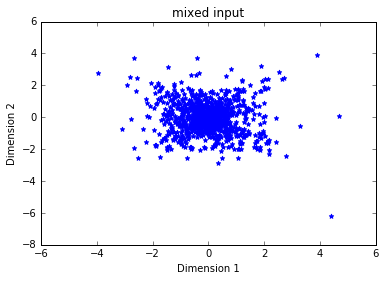

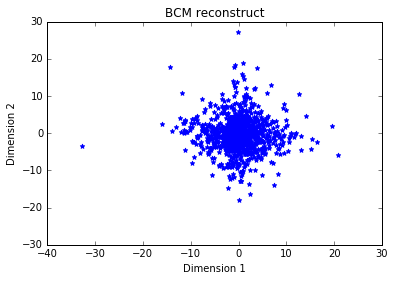

In [58]:
print(BCM_laplace.w_)

# Use the weights to reconstruct the input
s_rc = np.dot(s_rt,BCM_laplace.w_)

# Generate 2d satter plot of the input data
plt.scatter(s_rt[:,0],s_rt[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.title('mixed input')
plt.figure()
# Generate 2d satter plot of the reconstructed data
plt.scatter(s_rc[:,0],s_rc[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.title('BCM reconstruct')


Extracting the top 2 ica components from 1000 samples
done in 0.003s


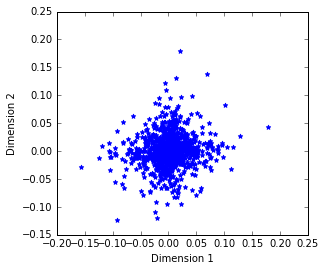

In [12]:
# Use fast ICA and see weights and results

from sklearn.decomposition import FastICA
from time import time
# Compute the ICA (eigendigits) on the digits
n_components = 2

print("Extracting the top %d ica components from %d samples" % (n_components,s_rt.shape[0]))
t0 = time()
ica_s = FastICA(n_components = n_components, whiten = True).fit(s_rt)
print("done in %0.3fs" % (time()-t0))

# Use the weights to reconstruct the input
w = ica_s.components_
s_rc = np.dot(s_rt,w)

# Generate 2d satter plot of the reconstructed data
plt.scatter(s_rc[:,0],s_rc[:,1],color = 'blue', marker = '*')
plt.xlabel ('Dimension 1')
plt.ylabel ('Dimension 2')
plt.gca().set_aspect(1)

In [85]:
# Define BCM class by quadratic learning rule
# Use iterative objective function
# Use tolerance to control # of iterations

class BCM:
    """BCM learning
    Parameter:
    eta: float, learning rate (between 0.0 - 1.0)
    n_iter: int, passes over the training dataset
    ny: number of output neurons
    batchsize: float, percentage of data that are used to update the weight once
    
    Attributes:
    w_: 1d-array, weights after fitting
    error_: list, number of misclassification in every epoch
    """
    def __init__(self, eta = 0.1,n_epoch = 10,ny = 1,tau = 10, batchsize = 10,thres = 0, p = 2,random_state = None, shuffle = True):
        self.eta = eta
        self.n_epoch = n_epoch
        self.ny = ny
        self.batchsize = batchsize
        self.tau = tau  # Time constant for calculating thresholds
        self.thres = [thres*np.ones(ny)]
        self.p = p    # int, power for threshold computation
        self.y_thres = []      # Storaged y for studying effect of threshold
        self.shuffle = shuffle
        
        if random_state:
            seed(random_state)
            
    def fit(self,X):
        """fitting training data
        Parameter:
        X: {array-like}, shape = [n_samples,n_features]
        Returns: self:object
        ny: value, number of output neurons
        """
        # Weights initialized as normal distribution
        self.w_ = np.random.randn(X.shape[1],self.ny) # 2*1
        self.w_track = []
#         np.zeros(self.n_epoch*X.shape[0],X.shape[1]*self.ny)   # n_interation rows, weight number of columns
        
        # Use elementwise training 
        threshold = np.zeros(2)
        for _ in range(self.n_epoch):
            if self.shuffle:
                X = self._shuffle(X)
            for i, xi in enumerate(X):   # elementwise training for all samples
                theta = np.zeros(2)
                y = np.zeros(2)
                for j in range(self.ny):
                    y[j] = np.dot(xi,self.w_[:,j])     
                    if y[j]<0:
                        y[j] = 0
                    self.w_[:,j][:,None] = self.w_[:,j][:,None]+ self.eta * xi[:,None]* y[j]*(y[j] - threshold[j])
                    h = np.exp(-1/self.tau)
                    y_power = y[j]**2
                    theta[j] = threshold[j]*self.tau*h+y_power
                    theta[j] = theta[j]/self.tau
                w_tmp = np.concatenate(self.w_.T, axis=0)    # make 2*2 matrix into 1*4, preparing for weight tracking
                self.y_thres.append(y)
                self.thres.append(theta)
                self.w_track.append(w_tmp.tolist())
                threshold = theta
        return self
    
    def _shuffle(self,X):
        r = np.random.permutation(len(X))
        return X[r]

In [86]:
ny = 2    # 2 output neurons
n_epoch = 20
p = 2
eta = 0.0005
tau = 200
BCM_laplace = BCM_tol(eta = eta,n_epoch = n_epoch,ny = 2,tau = 200, batchsize = 0,thres = 0, p = p,random_state = None, shuffle = True)

t0 = time()
BCM_laplace.fit(s_rt[0:2])

done in 0.558s


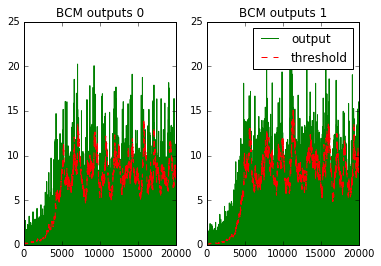

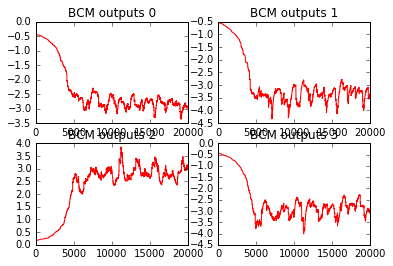

In [116]:
# Train BCM model with Laplace data

ny = 2    # 2 output neurons
n_epoch = 20
p = 2
eta = 0.0005
tau = 200
BCM_laplace = BCM_tol(eta = eta,n_epoch = n_epoch,ny = 2,tau = 200, batchsize = 0,thres = 0, p = p,random_state = None, shuffle = True)

t0 = time()
BCM_laplace.fit(s_rt)
print("done in %0.3fs" % (time()-t0))

#x_plot = range(n_iter * len(X))
plt_range = n_iter * len(s_rt)
BCM_laplace_thres = np.vstack(BCM_laplace.thres)
BCM_laplace_out = np.vstack(BCM_laplace.y_thres)
BCM_laplace_w = np.vstack(BCM_laplace.w_track)

n_row = 1
n_column = ny

BCM_laplace_titles= ["BCM outputs %d" % i for i in range (ny)]
# Plot y and threshold
for i in range(ny):
    plt.subplot(n_row,n_column,i+1)
    plt.plot(BCM_laplace_out[:plt_range,i],'g-',label = 'output')
    plt.plot(BCM_laplace_thres[:plt_range,i],'r--',label = 'threshold')
    plt.title(BCM_laplace_titles[i])

plt.legend(loc = 'upper right')

plt.figure()
# Plot weights

BCM_laplace_titles= ["BCM outputs %d" % i for i in range (len(BCM_laplace_w.T))]

for j in range(len(BCM_laplace_w.T)):
    plt.subplot(n_row*2,ny,j+1)
    plt.plot(BCM_laplace_w[:,j],'r',label = 'weight')
    BCMlaplace_title_w = ["BCM weights %d" % j]
    plt.title(BCM_laplace_titles[j])




In [101]:
len(BCM_laplace_w.T)

4

In [64]:
BCM_laplace.w_track[1]

[[-0.5850925725154572, 0.62239522037413],
 [-0.9468478509582837, -0.5275095744048588]]

[[-2.95239092  3.13749205]
 [-3.34909109 -3.07653676]]


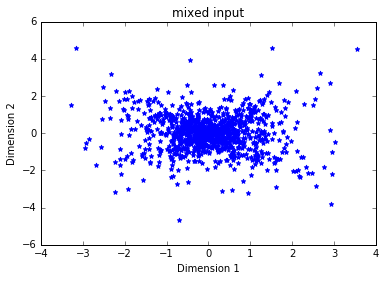

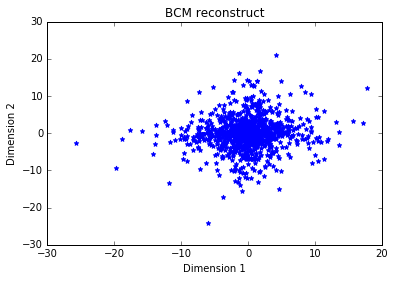